# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 6s 54ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 11s - loss: 18.9493 - energy_loss: 0.2303 - force_loss: 0.9360 - 11s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9188 - energy_loss: 0.2099 - force_loss: 0.9354 - 587ms/epoch - 73ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.8831 - energy_loss: 0.2150 - force_loss: 0.9334 - 592ms/epoch - 74ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.7143 - energy_loss: 0.2488 - force_loss: 0.9233 - 584ms/epoch - 73ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.5554 - energy_loss: 0.4021 - force_loss: 0.9077 - 583ms/epoch - 73ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.1943 - energy_loss: 0.3454 - force_loss: 0.8924 - 583ms/epoch - 73ms/step
Epoch 7/1500
8/8 - 1s - loss: 17.7579 - energy_loss: 0.6452 - force_loss: 0.8556 - 582ms/epoch - 73ms/step
Epoch 8/1500
8/8 - 1s - loss: 16.9282 - energy_loss: 0.6940 - force_loss: 0.8117 - 583ms/epoch - 73ms/step
Epoch 9/1500
8/8 - 1s - loss: 19.1140 - energy_loss: 2.9005 - force_loss: 0.8107 - 585ms/epoch - 73ms/step
Epoch 10/1500
8/8 - 1s - loss: 18.1483 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.5522 - energy_loss: 0.8234 - force_loss: 0.2864 - 566ms/epoch - 71ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.4177 - energy_loss: 0.7933 - force_loss: 0.2812 - 569ms/epoch - 71ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.3562 - energy_loss: 0.8146 - force_loss: 0.2771 - 575ms/epoch - 72ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.3692 - energy_loss: 0.8117 - force_loss: 0.2779 - 575ms/epoch - 72ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.3158 - energy_loss: 0.8219 - force_loss: 0.2747 - 570ms/epoch - 71ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.2914 - energy_loss: 0.8190 - force_loss: 0.2736 - 574ms/epoch - 72ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.2242 - energy_loss: 0.8056 - force_loss: 0.2709 - 576ms/epoch - 72ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.1880 - energy_loss: 0.8116 - force_loss: 0.2688 - 567ms/epoch - 71ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.1036 - energy_loss: 0.7989 - force_loss: 0.2652 - 572ms/epoch - 71ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.0645

8/8 - 1s - loss: 4.2565 - energy_loss: 0.6373 - force_loss: 0.1810 - 567ms/epoch - 71ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.2776 - energy_loss: 0.6683 - force_loss: 0.1805 - 587ms/epoch - 73ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.4163 - energy_loss: 0.6799 - force_loss: 0.1868 - 570ms/epoch - 71ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.4430 - energy_loss: 0.6982 - force_loss: 0.1872 - 617ms/epoch - 77ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.2883 - energy_loss: 0.6046 - force_loss: 0.1842 - 573ms/epoch - 72ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.3620 - energy_loss: 0.6932 - force_loss: 0.1834 - 565ms/epoch - 71ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.1725 - energy_loss: 0.5811 - force_loss: 0.1796 - 564ms/epoch - 70ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.1200 - energy_loss: 0.6411 - force_loss: 0.1739 - 595ms/epoch - 74ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.1197 - energy_loss: 0.6695 - force_loss: 0.1725 - 568ms/epoch - 71ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.0189 - en

Epoch 230/1500
8/8 - 1s - loss: 3.8119 - energy_loss: 0.5964 - force_loss: 0.1608 - 578ms/epoch - 72ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.6661 - energy_loss: 0.5232 - force_loss: 0.1571 - 569ms/epoch - 71ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.5915 - energy_loss: 0.5656 - force_loss: 0.1513 - 566ms/epoch - 71ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.4959 - energy_loss: 0.5195 - force_loss: 0.1488 - 569ms/epoch - 71ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.5529 - energy_loss: 0.5835 - force_loss: 0.1485 - 575ms/epoch - 72ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.4943 - energy_loss: 0.5257 - force_loss: 0.1484 - 567ms/epoch - 71ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.4855 - energy_loss: 0.5245 - force_loss: 0.1480 - 566ms/epoch - 71ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.3918 - energy_loss: 0.5280 - force_loss: 0.1432 - 573ms/epoch - 72ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.3226 - energy_loss: 0.4843 - force_loss: 0.1419 - 595ms/epoch - 74ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 2.9737 - energy_loss: 0.2716 - force_loss: 0.1351 - 576ms/epoch - 72ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.2249 - energy_loss: 0.6047 - force_loss: 0.1310 - 580ms/epoch - 72ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.1386 - energy_loss: 0.4886 - force_loss: 0.1325 - 578ms/epoch - 72ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.0404 - energy_loss: 0.4349 - force_loss: 0.1303 - 568ms/epoch - 71ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.2098 - energy_loss: 0.5837 - force_loss: 0.1313 - 582ms/epoch - 73ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.0880 - energy_loss: 0.4839 - force_loss: 0.1302 - 578ms/epoch - 72ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.1783 - energy_loss: 0.4602 - force_loss: 0.1359 - 580ms/epoch - 72ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.2646 - energy_loss: 0.4594 - force_loss: 0.1403 - 572ms/epoch - 72ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.2196 - energy_loss: 0.4423 - force_loss: 0.1389 - 576ms/epoch - 72ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 2.7893 - energy_loss: 0.4163 - force_loss: 0.1187 - 622ms/epoch - 78ms/step
Epoch 383/1500
8/8 - 1s - loss: 2.8473 - energy_loss: 0.4488 - force_loss: 0.1199 - 603ms/epoch - 75ms/step
Epoch 384/1500
8/8 - 1s - loss: 2.6223 - energy_loss: 0.3013 - force_loss: 0.1161 - 706ms/epoch - 88ms/step
Epoch 385/1500
8/8 - 1s - loss: 2.4899 - energy_loss: 0.2194 - force_loss: 0.1135 - 623ms/epoch - 78ms/step
Epoch 386/1500
8/8 - 1s - loss: 2.5166 - energy_loss: 0.2259 - force_loss: 0.1145 - 615ms/epoch - 77ms/step
Epoch 387/1500
8/8 - 1s - loss: 2.6438 - energy_loss: 0.3715 - force_loss: 0.1136 - 582ms/epoch - 73ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.8602 - energy_loss: 0.4519 - force_loss: 0.1204 - 572ms/epoch - 72ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.8358 - energy_loss: 0.4244 - force_loss: 0.1206 - 583ms/epoch - 73ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.8500 - energy_loss: 0.4505 - force_loss: 0.1200 - 567ms/epoch - 71ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 3.0163 - energy_loss: 0.4292 - force_loss: 0.1294 - 599ms/epoch - 75ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.7978 - energy_loss: 0.4014 - force_loss: 0.1198 - 599ms/epoch - 75ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.9261 - energy_loss: 0.4336 - force_loss: 0.1246 - 595ms/epoch - 74ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.8285 - energy_loss: 0.4200 - force_loss: 0.1204 - 604ms/epoch - 76ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.6714 - energy_loss: 0.4171 - force_loss: 0.1127 - 595ms/epoch - 74ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.7116 - energy_loss: 0.3802 - force_loss: 0.1166 - 592ms/epoch - 74ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.7499 - energy_loss: 0.4242 - force_loss: 0.1163 - 600ms/epoch - 75ms/step
Epoch 465/1500
8/8 - 1s - loss: 3.0971 - energy_loss: 0.8107 - force_loss: 0.1143 - 596ms/epoch - 74ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.6913 - energy_loss: 0.4397 - force_loss: 0.1126 - 625ms/epoch - 78ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.4396 - energy_loss: 0.3494 - force_loss: 0.1045 - 567ms/epoch - 71ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.5181 - energy_loss: 0.4918 - force_loss: 0.1013 - 566ms/epoch - 71ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.4213 - energy_loss: 0.3992 - force_loss: 0.1011 - 569ms/epoch - 71ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.4576 - energy_loss: 0.4406 - force_loss: 0.1009 - 570ms/epoch - 71ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.3673 - energy_loss: 0.3893 - force_loss: 0.0989 - 581ms/epoch - 73ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.3582 - energy_loss: 0.3632 - force_loss: 0.0997 - 576ms/epoch - 72ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.4126 - energy_loss: 0.3834 - force_loss: 0.1015 - 592ms/epoch - 74ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.4471 - energy_loss: 0.4502 - force_loss: 0.0998 - 586ms/epoch - 73ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.3573 - energy_loss: 0.3355 - force_loss: 0.1011 - 576ms/epoch - 72ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 1.9990 - energy_loss: 0.1958 - force_loss: 0.0902 - 600ms/epoch - 75ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.1389 - energy_loss: 0.2948 - force_loss: 0.0922 - 597ms/epoch - 75ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.3355 - energy_loss: 0.4137 - force_loss: 0.0961 - 609ms/epoch - 76ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.5118 - energy_loss: 0.5527 - force_loss: 0.0980 - 595ms/epoch - 74ms/step
Epoch 614/1500
8/8 - 1s - loss: 3.3014 - energy_loss: 1.3417 - force_loss: 0.0980 - 591ms/epoch - 74ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.4622 - energy_loss: 0.4276 - force_loss: 0.1017 - 581ms/epoch - 73ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.4229 - energy_loss: 0.2849 - force_loss: 0.1069 - 593ms/epoch - 74ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.2562 - energy_loss: 0.1957 - force_loss: 0.1030 - 596ms/epoch - 74ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.7361 - energy_loss: 0.7179 - force_loss: 0.1009 - 570ms/epoch - 71ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.4549 - energy_loss: 0.3607 - force_loss: 0.1047 - 569ms/epoch - 71ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.5054 - energy_loss: 0.3569 - force_loss: 0.1074 - 560ms/epoch - 70ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.5428 - energy_loss: 0.3880 - force_loss: 0.1077 - 570ms/epoch - 71ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.3763 - energy_loss: 0.3854 - force_loss: 0.0995 - 567ms/epoch - 71ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.4763 - energy_loss: 0.3577 - force_loss: 0.1059 - 565ms/epoch - 71ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.4316 - energy_loss: 0.3560 - force_loss: 0.1038 - 563ms/epoch - 70ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.5085 - energy_loss: 0.3641 - force_loss: 0.1072 - 567ms/epoch - 71ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.2845 - energy_loss: 0.3543 - force_loss: 0.0965 - 565ms/epoch - 71ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.2290 - energy_loss: 0.3509 - force_loss: 0.0939 - 565ms/epoch - 71ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.6151 - energy_loss: 0.3786 - force_loss: 0.1118 - 569ms/epoch - 71ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.5379 - energy_loss: 0.4103 - force_loss: 0.1064 - 573ms/epoch - 72ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.4637 - energy_loss: 0.3763 - force_loss: 0.1044 - 572ms/epoch - 72ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.3165 - energy_loss: 0.3588 - force_loss: 0.0979 - 566ms/epoch - 71ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.2444 - energy_loss: 0.3439 - force_loss: 0.0950 - 573ms/epoch - 72ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.3387 - energy_loss: 0.3321 - force_loss: 0.1003 - 575ms/epoch - 72ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.3737 - energy_loss: 0.3927 - force_loss: 0.0991 - 566ms/epoch - 71ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.1973 - energy_loss: 0.3411 - force_loss: 0.0928 - 569ms/epoch - 71ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.2076 - energy_loss: 0.3590 - force_loss: 0.0924 - 572ms/epoch - 71ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.4843 - energy_loss: 0.5863 - force_loss: 0.0949 - 575ms/epoch - 72ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.5039 - energy_loss: 0.5433 - force_loss: 0.0980 - 569ms/epoch - 71ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.4223 - energy_loss: 0.4762 - force_loss: 0.0973 - 572ms/epoch - 71ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.4703 - energy_loss: 0.2951 - force_loss: 0.1088 - 567ms/epoch - 71ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.8590 - energy_loss: 0.6573 - force_loss: 0.1101 - 568ms/epoch - 71ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.3070 - energy_loss: 0.1669 - force_loss: 0.1070 - 572ms/epoch - 71ms/step
Epoch 844/1500
8/8 - 1s - loss: 2.0314 - energy_loss: 0.1763 - force_loss: 0.0928 - 571ms/epoch - 71ms/step
Epoch 845/1500
8/8 - 1s - loss: 2.1449 - energy_loss: 0.3660 - force_loss: 0.0889 - 572ms/epoch - 71ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.1959 - energy_loss: 0.3655 - force_loss: 0.0915 - 571ms/epoch - 71ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 1.9175 - energy_loss: 0.3211 - force_loss: 0.0798 - 561ms/epoch - 70ms/step
Epoch 915/1500
8/8 - 1s - loss: 1.9475 - energy_loss: 0.3281 - force_loss: 0.0810 - 560ms/epoch - 70ms/step
Epoch 916/1500
8/8 - 1s - loss: 2.0240 - energy_loss: 0.3043 - force_loss: 0.0860 - 563ms/epoch - 70ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.0171 - energy_loss: 0.2930 - force_loss: 0.0862 - 566ms/epoch - 71ms/step
Epoch 918/1500
8/8 - 1s - loss: 2.1161 - energy_loss: 0.2809 - force_loss: 0.0918 - 562ms/epoch - 70ms/step
Epoch 919/1500
8/8 - 1s - loss: 2.0962 - energy_loss: 0.2392 - force_loss: 0.0928 - 593ms/epoch - 74ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.0235 - energy_loss: 0.3449 - force_loss: 0.0839 - 629ms/epoch - 79ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.0475 - energy_loss: 0.3232 - force_loss: 0.0862 - 585ms/epoch - 73ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.1209 - energy_loss: 0.3298 - force_loss: 0.0896 - 584ms/epoch - 73ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.1514 - energy_loss: 0.1667 - force_loss: 0.0992 - 574ms/epoch - 72ms/step
Epoch 991/1500
8/8 - 1s - loss: 2.0404 - energy_loss: 0.2516 - force_loss: 0.0894 - 564ms/epoch - 70ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.9217 - energy_loss: 0.1668 - force_loss: 0.0877 - 567ms/epoch - 71ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.7099 - energy_loss: 0.1447 - force_loss: 0.0783 - 571ms/epoch - 71ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.6949 - energy_loss: 0.1483 - force_loss: 0.0773 - 570ms/epoch - 71ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.7019 - energy_loss: 0.1505 - force_loss: 0.0776 - 612ms/epoch - 76ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.6520 - energy_loss: 0.1128 - force_loss: 0.0770 - 569ms/epoch - 71ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.6650 - energy_loss: 0.1372 - force_loss: 0.0764 - 566ms/epoch - 71ms/step
Epoch 998/1500
8/8 - 1s - loss: 1.8613 - energy_loss: 0.3017 - force_loss: 0.0780 - 566ms/epoch - 71ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.9604 - energy_loss: 0.3218 - force_loss: 0.0819 - 565ms/epoch - 71ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.9655 - energy_loss: 0.3048 - force_loss: 0.0830 - 560ms/epoch - 70ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.9228 - energy_loss: 0.3165 - force_loss: 0.0803 - 557ms/epoch - 70ms/step
Epoch 1069/1500
8/8 - 1s - loss: 1.9277 - energy_loss: 0.3012 - force_loss: 0.0813 - 560ms/epoch - 70ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.0244 - energy_loss: 0.3084 - force_loss: 0.0858 - 561ms/epoch - 70ms/step
Epoch 1071/1500
8/8 - 1s - loss: 2.0524 - energy_loss: 0.3237 - force_loss: 0.0864 - 565ms/epoch - 71ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.9873 - energy_loss: 0.3125 - force_loss: 0.0837 - 557ms/epoch - 70ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.9213 - energy_loss: 0.2805 - force_loss: 0.0820 - 562ms/epoch - 70ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.9769 - energy_loss: 0.3932 - force_loss: 0.0792 - 564ms/epoch - 70ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.5419 - energy_loss: 0.1475 - force_loss: 0.0697 - 561ms/epoch - 70ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.5268 - energy_loss: 0.1265 - force_loss: 0.0700 - 565ms/epoch - 71ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.5291 - energy_loss: 0.1419 - force_loss: 0.0694 - 563ms/epoch - 70ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.7973 - energy_loss: 0.2908 - force_loss: 0.0753 - 567ms/epoch - 71ms/step
Epoch 1146/1500
8/8 - 1s - loss: 2.1918 - energy_loss: 0.5747 - force_loss: 0.0809 - 574ms/epoch - 72ms/step
Epoch 1147/1500
8/8 - 1s - loss: 2.3468 - energy_loss: 0.7967 - force_loss: 0.0775 - 568ms/epoch - 71ms/step
Epoch 1148/1500
8/8 - 1s - loss: 2.4313 - energy_loss: 0.9062 - force_loss: 0.0763 - 581ms/epoch - 73ms/step
Epoch 1149/1500
8/8 - 1s - loss: 2.0549 - energy_loss: 0.5035 - force_loss: 0.0776 - 584ms/epoch - 73ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.6877 - energy_loss: 0.1344 - force_loss: 0.0777 - 570ms/epoch - 71ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 2.0018 - energy_loss: 0.2888 - force_loss: 0.0856 - 564ms/epoch - 70ms/step
Epoch 1219/1500
8/8 - 1s - loss: 2.1617 - energy_loss: 0.2941 - force_loss: 0.0934 - 559ms/epoch - 70ms/step
Epoch 1220/1500
8/8 - 1s - loss: 2.1860 - energy_loss: 0.2623 - force_loss: 0.0962 - 565ms/epoch - 71ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.9716 - energy_loss: 0.2999 - force_loss: 0.0836 - 562ms/epoch - 70ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.9071 - energy_loss: 0.2999 - force_loss: 0.0804 - 597ms/epoch - 75ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.8074 - energy_loss: 0.1622 - force_loss: 0.0823 - 606ms/epoch - 76ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.7055 - energy_loss: 0.1496 - force_loss: 0.0778 - 623ms/epoch - 78ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.5838 - energy_loss: 0.1547 - force_loss: 0.0715 - 596ms/epoch - 74ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.9494 - energy_loss: 0.5145 - force_loss: 0.0717 - 560ms/epoch - 70ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.6953 - energy_loss: 0.2390 - force_loss: 0.0728 - 567ms/epoch - 71ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.6926 - energy_loss: 0.2889 - force_loss: 0.0702 - 565ms/epoch - 71ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.6148 - energy_loss: 0.1235 - force_loss: 0.0746 - 562ms/epoch - 70ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.5492 - energy_loss: 0.1819 - force_loss: 0.0684 - 570ms/epoch - 71ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.5872 - energy_loss: 0.2293 - force_loss: 0.0679 - 567ms/epoch - 71ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.4704 - energy_loss: 0.1400 - force_loss: 0.0665 - 574ms/epoch - 72ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.5173 - energy_loss: 0.1391 - force_loss: 0.0689 - 573ms/epoch - 72ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.8184 - energy_loss: 0.4411 - force_loss: 0.0689 - 567ms/epoch - 71ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.7315 - energy_loss: 0.3336 - force_loss: 0.0699 - 566ms/epoch - 71ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.5570 - energy_loss: 0.2547 - force_loss: 0.0651 - 557ms/epoch - 70ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.6490 - energy_loss: 0.2593 - force_loss: 0.0695 - 559ms/epoch - 70ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7482 - energy_loss: 0.2831 - force_loss: 0.0733 - 570ms/epoch - 71ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7270 - energy_loss: 0.1637 - force_loss: 0.0782 - 569ms/epoch - 71ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.5670 - energy_loss: 0.1385 - force_loss: 0.0714 - 576ms/epoch - 72ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.5619 - energy_loss: 0.2454 - force_loss: 0.0658 - 567ms/epoch - 71ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.4734 - energy_loss: 0.1416 - force_loss: 0.0666 - 584ms/epoch - 73ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.6105 - energy_loss: 0.2505 - force_loss: 0.0680 - 558ms/epoch - 70ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6121 - energy_loss: 0.2157 - force_loss: 0.0698 - 549ms/epoch - 69ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6763 - energy_loss: 0.2764 - force_loss: 0.0700 - 540ms/epoch - 67ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7580 - energy_loss: 0.2777 - force_loss: 0.0740 - 542ms/epoch - 68ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.8421 - energy_loss: 0.2753 - force_loss: 0.0783 - 539ms/epoch - 67ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8071 - energy_loss: 0.2737 - force_loss: 0.0767 - 537ms/epoch - 67ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.7470 - energy_loss: 0.2751 - force_loss: 0.0736 - 537ms/epoch - 67ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.8517 - energy_loss: 0.2837 - force_loss: 0.0784 - 537ms/epoch - 67ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.7919 - energy_loss: 0.2693 - force_loss: 0.0761 - 534ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.6473 - energy_loss: 0.2307 - force_loss: 0.0708 - 537ms/epoch - 67ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.6641 - energy_loss: 0.3051 - force_loss: 0.0679 - 554ms/epoch - 69ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

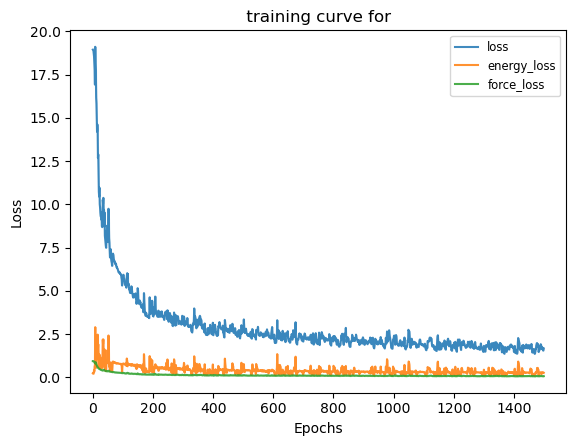

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.moldyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [19]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates= "coords")],
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, force="forces", atomic_number="nuclear_charges")]
)

In [20]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17470.31332771]),
 'forces': array([[-2.6408393e+00,  2.5365398e+00, -7.4318409e-01],
        [-8.6926728e-01, -7.8471678e-01,  1.8671615e+00],
        [ 3.1378684e+00, -2.2194939e+00, -2.0148766e-01],
        [-3.6528349e-01,  1.7158732e+00, -1.9941989e-01],
        [ 8.9164384e-02,  1.8975844e+00,  8.8080227e-01],
        [-5.6581408e-01,  1.5084130e-01,  1.9899383e-03],
        [-2.6121438e-02,  8.5225910e-01, -2.0291040e+00],
        [-3.3121011e-01, -1.3121438e+00, -8.6958632e-02],
        [ 5.1546848e-01,  3.8789611e+00,  2.0755565e+00],
        [-7.5763160e-01,  2.2297416e+00,  7.1944159e-01],
        [ 1.3507282e+00, -1.2911147e+00,  5.0832886e-01],
        [ 5.6364828e-01, -3.8281655e+00, -2.0136442e+00],
        [ 1.8341212e+00, -1.0649298e+00, -7.0893931e-01],
        [-2.8200647e-01, -5.9100521e-01,  4.3825206e-01],
        [ 1.1019393e+00, -1.7312194e+00,  1.2588949e+00],
        [ 1.2288073e-01,  2.6025897e-01, -8.0366659e-01],
        [-1.1724020e+00, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [23]:
from ase import Atoms
from kgcnn.moldyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [24]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [25]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [26]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [27]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [28]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17470.31332783), 'forces': array([[-2.64084053e+00,  2.53654075e+00, -7.43184090e-01],
       [-8.69267523e-01, -7.84716904e-01,  1.86716282e+00],
       [ 3.13786817e+00, -2.21949363e+00, -2.01487601e-01],
       [-3.65282655e-01,  1.71587360e+00, -1.99420929e-01],
       [ 8.91653821e-02,  1.89758492e+00,  8.80802691e-01],
       [-5.65814078e-01,  1.50839925e-01,  1.98882818e-03],
       [-2.61216164e-02,  8.52258503e-01, -2.02910423e+00],
       [-3.31210554e-01, -1.31214345e+00, -8.69579166e-02],
       [ 5.15469015e-01,  3.87896132e+00,  2.07555652e+00],
       [-7.57631361e-01,  2.22974229e+00,  7.19441772e-01],
       [ 1.35072851e+00, -1.29111433e+00,  5.08328974e-01],
       [ 5.63647449e-01, -3.82816410e+00, -2.01364398e+00],
       [ 1.83412111e+00, -1.06492925e+00, -7.08940029e-01],
       [-2.82006323e-01, -5.91005206e-01,  4.38251704e-01],
       [ 1.10193968e+00, -1.73121965e+00,  1.25889480e+00],
       [ 1.22880965e-01,  2.60258913e-01, -8.03666472e-

In [29]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.920eV  Ekin = 0.034eV (T=266K)  Etot = -831.885eV


Energy per atom: Epot = -831.932eV  Ekin = 0.047eV (T=361K)  Etot = -831.885eV
Energy per atom: Epot = -831.935eV  Ekin = 0.049eV (T=377K)  Etot = -831.886eV
Energy per atom: Epot = -831.923eV  Ekin = 0.038eV (T=295K)  Etot = -831.885eV
Energy per atom: Epot = -831.927eV  Ekin = 0.049eV (T=383K)  Etot = -831.877eV
Energy per atom: Epot = -831.946eV  Ekin = 0.066eV (T=512K)  Etot = -831.880eV
Energy per atom: Epot = -831.937eV  Ekin = 0.054eV (T=415K)  Etot = -831.883eV
Energy per atom: Epot = -831.940eV  Ekin = 0.057eV (T=444K)  Etot = -831.883eV
Energy per atom: Epot = -831.930eV  Ekin = 0.056eV (T=435K)  Etot = -831.874eV
Energy per atom: Epot = -831.922eV  Ekin = 0.047eV (T=363K)  Etot = -831.875eV
Energy per atom: Epot = -831.939eV  Ekin = 0.060eV (T=464K)  Etot = -831.879eV
Energy per atom: Epot = -831.934eV  Ekin = 0.052eV (T=404K)  Etot = -831.882eV
Energy per atom: Epot = -831.923eV  Ekin = 0.047eV (T=367K)  Etot = -831.875eV
Energy per atom: Epot = -831.927eV  Ekin = 0.049eV (